In [1]:
## General imports
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm
import seaborn as sns
import pickle
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

In [2]:
## Download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/FeDX3LfbJ4pC7T6')

In [3]:
## Create data for randomly simulating place cell activity
def simulate_place_cells(track_length = 200,average_firing_rate = 5,n_cells = 100):
    # The track_length is thr length of our linear track (eg in centimeter)
    # The average_firing_rate is the peak firing rate, averaged across the population 
    # The n_cells is the amount of cells that we are recording
    
    pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
    pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
    pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution
    return pf_centers,pf_size,pf_rate

In [4]:
def create_data(pf_centers,pf_size,pf_rate,n_cells=100,track_length=200):
    bins = np.arange(0., track_length)
    true_firing_rate_maps = np.zeros((n_cells, len(bins)), dtype=float, order='C')
    for i in range(n_cells):
        true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))
    return true_firing_rate_maps

In [5]:
def mouse_trajectory(track_length=200):
    bins = np.arange(0., track_length)
    n_runs = 20 
    av_running_speed = 10 # the average running speed (in cm/s)
    fps = 30 # the number of "video frames" per second 
    running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
    running_speed_b = np.random.chisquare(10, size=n_runs) 

    stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
    stopping_time_b = np.random.chisquare(15, size=n_runs)

    x = np.array([])
    for i in range(n_runs):
        stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
        run_length = len(bins) * fps / running_speed_a[i]
        run1 = np.linspace(0., float(len(bins)-1), int(run_length))
        stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
        run_length = len(bins) * fps / running_speed_b[i]
        run2 = np.linspace(len(bins)-1., 0., int(run_length))
        x = np.concatenate((x, stop1, run1, stop2, run2))
    t = np.arange(len(x))/fps
    return x,t

In [6]:
def draw_spikes(x,t,n_cells=100,noise_firing_rate = 0.1):
    # The noise_firing_rate is the baseline noise firing rate
    sampling_rate = 10000.
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x))
    spikes = []

    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)
    return spikes

In [7]:
def create_firing_rate_maps(spike_positions,track_length=200.,binsize=5):
    space_bins = np.arange(0., track_length, binsize)
    
    # we compute histograms for each cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

    # put them together into a matrix of floating point numbers (for plotting)
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps

    return spikes_hist / occupancy,occupancy     

In [8]:
def plot_firing_rate_maps(firing_rate_maps,track_length=200):
    plt.figure(figsize=(15,5))
    plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, track_length, 0, n_cells])
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')
    plt.colorbar()

# Exercises

## Exercise 1 - simulating place cells
---
Use the code we build to simulate place cells in the lesson.

A - Explore what happens when you change the binning in the definition of the firing rate maps (`space_bins`). Make it coarser or broader. 


B - In the spike train simulations, we add some "baseline" noise, not place-related to the firing. Which variable determines the noise level? Try to experiment with that variable and see what happens to the firing rate maps. What is the best approach to firing rate maps when the noise is high.


C - We could use other approaches to firing rate maps: for example make the binning very small (down to 1 cm, which is the resolution of our "video" data, and then applying a gaussian smoother. Scipy has a Gaussian smoother at `scipy.stats.gaussian_kde`. Read the documentation for that function and apply it to the data to define the smoothed firing rate maps. Again, change the noise levels and see how the smoother changes. 

D - When analyzing place fields, two important quantities are the place field center and the place field width. The place field center may be defined in many ways, but one is to compute the "center of mass" of the spikes according to the equation 

$$ c_{pf} = \frac{1}{N_{spikes}} \sum_{i} L_i $$ 

where the sum on $i$ runs on all spikes emitted by a cell and $L_i$ is the location at which the i-th spike was emitted. Calculate this for each cell. Compare with the "true" place field centers from the simulations (which variables are we talking about?) 


### A

Coding from the notebook 'tuning-curves' is put into multiple functions to be able to quickly change a parameter and still let the code look clear and structured.

In [9]:
## Parameters
fps = 30 # the number of "video frames" per second 
n_cells = 100 # how many cells we are recording
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 

In [10]:
pf_centers,pf_size,pf_rate = simulate_place_cells(track_length,average_firing_rate,n_cells)
true_firing_rate_maps = create_data(pf_centers,pf_size,pf_rate,n_cells,track_length)
x,t = mouse_trajectory(track_length)

In [11]:
spikes = draw_spikes(x,t)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


In [12]:
spike_positions = [np.interp(s, t, x) for s in spikes]

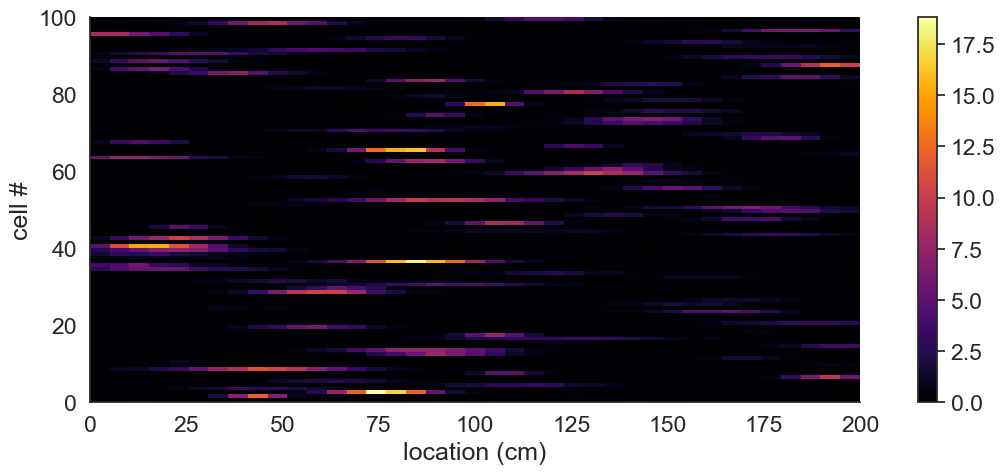

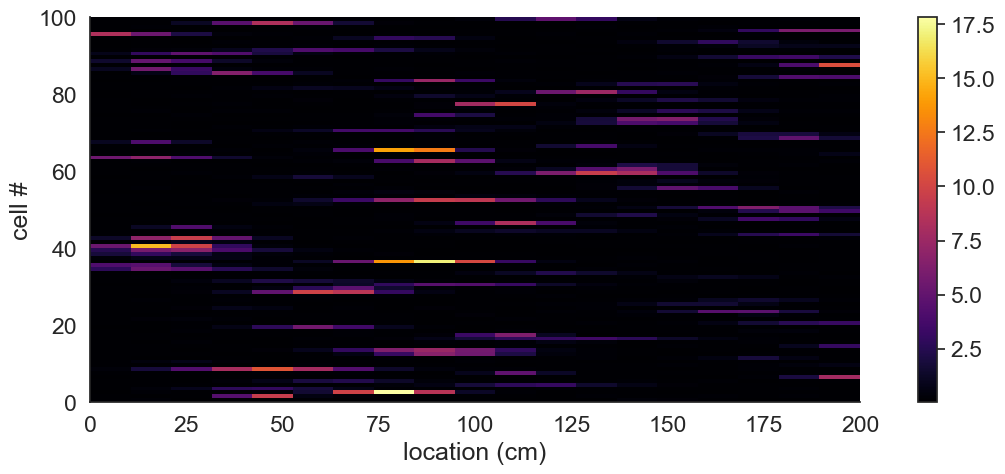

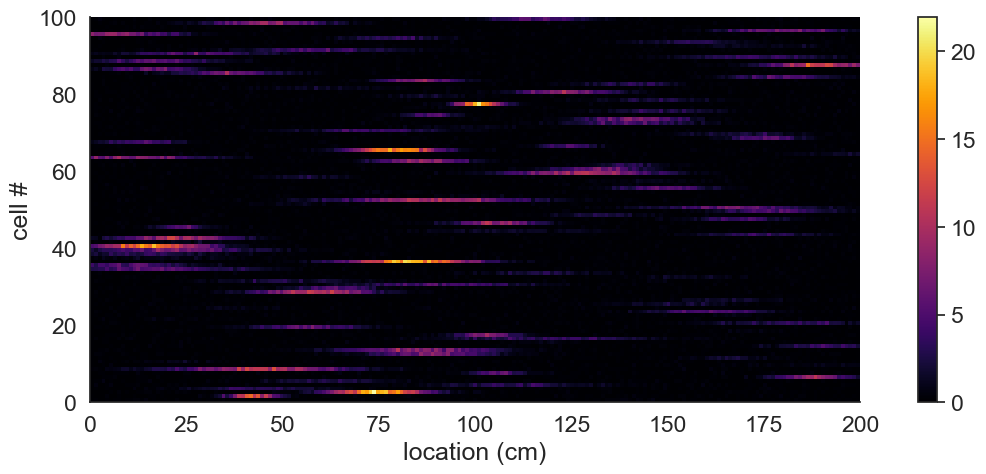

In [13]:
# Standard
firing_rate_maps,occupancy = create_firing_rate_maps(spike_positions,track_length,binsize=5)
plot_firing_rate_maps(firing_rate_maps)

# Broader
firing_rate_maps,occupancy = create_firing_rate_maps(spike_positions,track_length,binsize=10)
plot_firing_rate_maps(firing_rate_maps)

# Narrower
firing_rate_maps,occupancy = create_firing_rate_maps(spike_positions,track_length,binsize=1)
plot_firing_rate_maps(firing_rate_maps)


As the binsize is broaden, it becomes less clear where the peak of spike activity is precisely located. For a smaller binsize the location is more precise but the intensity overall has dropped a little bit since there are less spikes counted in the same bin.

### B

The variable 'noise_firing_rate' needs to be changed in order to change the amount of noise. The average peak firing rate of the place cells is 5. To have a 1:1 noise-firing rate the variable 'noise_firing_rate' is put to 5 as well.

In [14]:
spikes_noisy = draw_spikes(x,t,n_cells,noise_firing_rate = 5)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.19it/s]


In [15]:
spike_positions_noisy = [np.interp(s, t, x) for s in spikes_noisy]

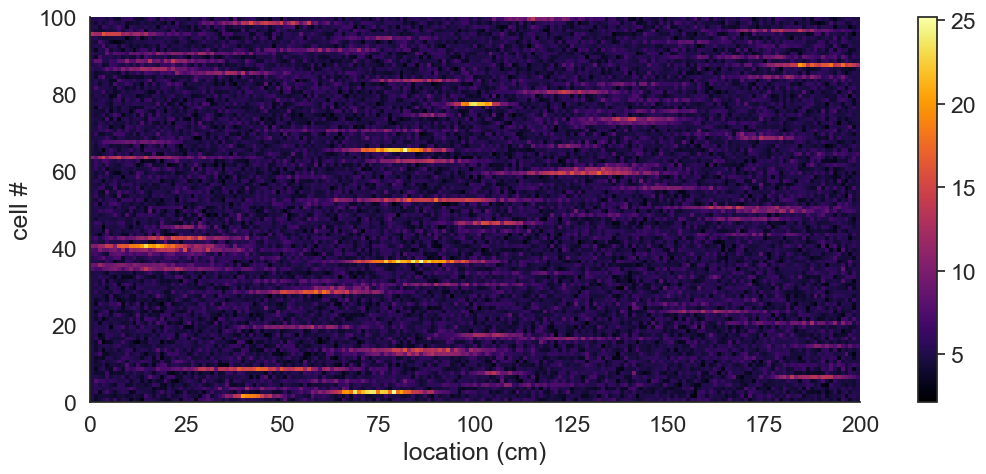

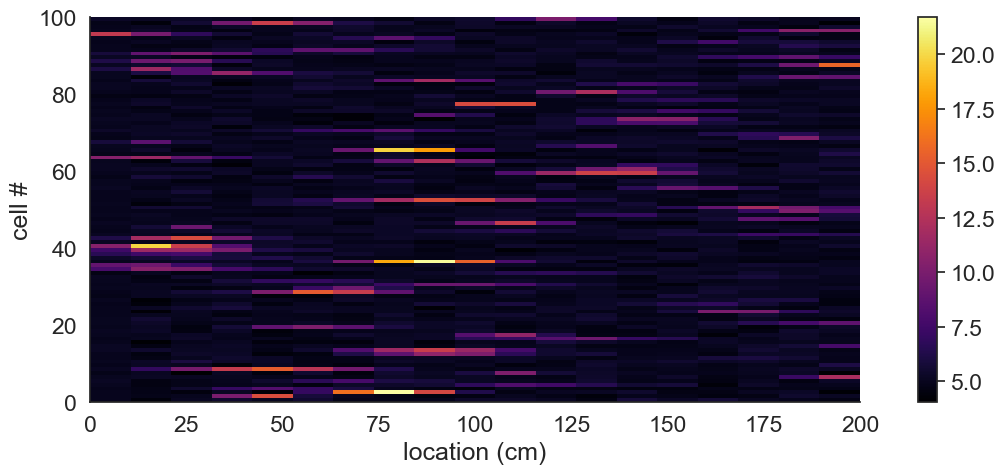

In [16]:
# Increased noise-level. Small binsize
firing_rate_maps_noisy,occupancy_noisy = create_firing_rate_maps(spike_positions_noisy,track_length,binsize=1)
plot_firing_rate_maps(firing_rate_maps_noisy)

# Increased noise-level. Large binsize
firing_rate_maps_noisy,occupancy_noisy = create_firing_rate_maps(spike_positions_noisy,track_length,binsize=10)
plot_firing_rate_maps(firing_rate_maps_noisy)

Since the background activity is relatively high, background is appearing clearly when the binsize is small. As the binsize is larger, the background noise get filtered out but at the same time the location of the peak becomes less precise.

### C

I didn't manage to apply the `scipy.stats.gaussian_kde` correctly as the peaks all got centered around the same location and not atits peak location (see code below). Therefore I applied a gaussian interpolation to in the next piece of code. However in this way the image gets smoothened in both x any y directions which is not preferable.

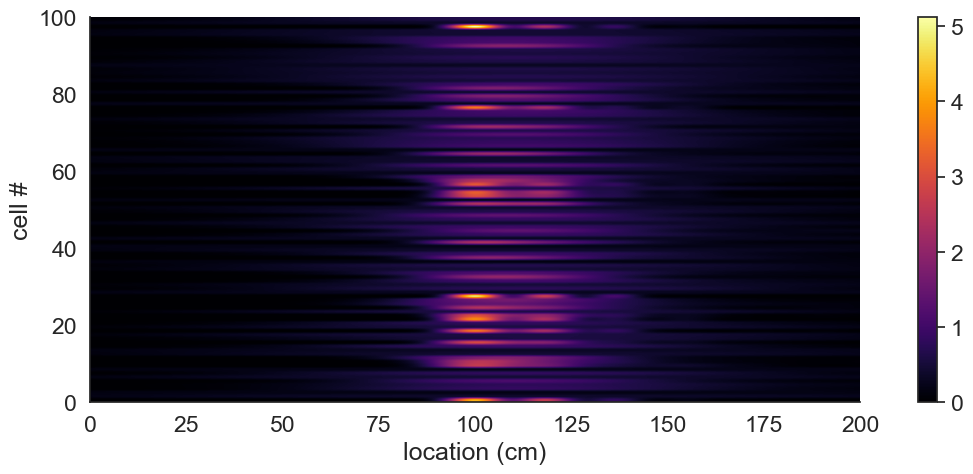

In [17]:
gaussian_y = [scipy.stats.gaussian_kde(firing_rate_maps[i],bw_method = None) for i in range(len(firing_rate_maps))]
time = [np.linspace(-1,1,1000) for i in range(len(firing_rate_maps))]
gkde_value = np.array([gaussian_y[i](time[i]) for i in range(len(firing_rate_maps))])

plot_firing_rate_maps(np.array(gkde_value))

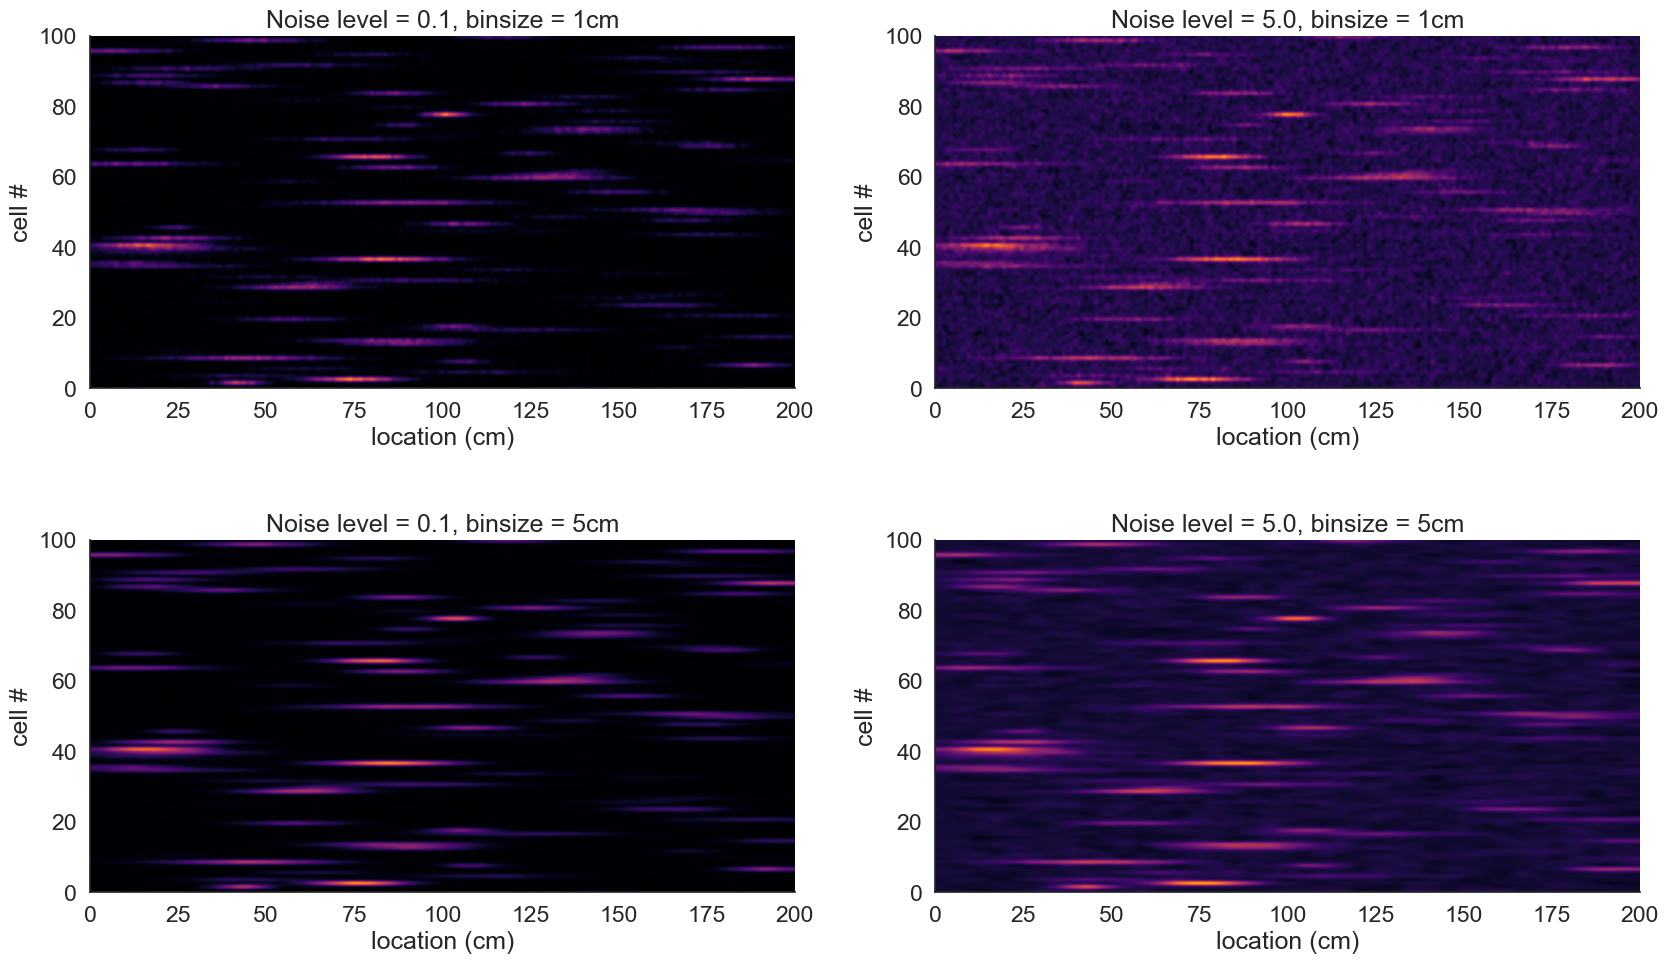

In [18]:
fig, axs = plt.subplots(2, 2,figsize=(20, 12))


firing_rate_maps,occupancy = create_firing_rate_maps(spike_positions,track_length,binsize=1)
axs[0, 0].imshow(firing_rate_maps, cmap='inferno', extent = [0, track_length, 0, n_cells],interpolation='gaussian')
axs[0, 0].set(xlabel='location (cm)', ylabel='cell #')
axs[0, 0].set_title('Noise level = 0.1, binsize = 1cm')

firing_rate_maps_noisy,occupancy_noisy = create_firing_rate_maps(spike_positions_noisy,track_length,binsize=1)
axs[0, 1].imshow(firing_rate_maps_noisy, cmap='inferno', extent = [0, track_length, 0, n_cells],interpolation='gaussian')
axs[0, 1].set(xlabel='location (cm)', ylabel='cell #')
axs[0, 1].set_title('Noise level = 5.0, binsize = 1cm')

firing_rate_maps,occupancy = create_firing_rate_maps(spike_positions,track_length,binsize=5)
axs[1, 0].imshow(firing_rate_maps, cmap='inferno', extent = [0, track_length, 0, n_cells],interpolation='gaussian')
axs[1, 0].set(xlabel='location (cm)', ylabel='cell #')
axs[1, 0].set_title('Noise level = 0.1, binsize = 5cm')

firing_rate_maps_noisy,occupancy_noisy= create_firing_rate_maps(spike_positions_noisy,track_length,binsize=5)
axs[1, 1].imshow(firing_rate_maps_noisy, cmap='inferno', extent = [0, track_length, 0, n_cells],interpolation='gaussian')
axs[1, 1].set(xlabel='location (cm)', ylabel='cell #')
axs[1, 1].set_title('Noise level = 5.0, binsize = 5cm')

plt.show()

Gaussian smoothening is a good method for finding the peak activity of a certain place cell and reducing the level of noise. Gaussian smoothing works the best if the binsize is not too small as can be seen in the subfigures below. Especially in the case of a high level of noise, it will be able to filter out some of the noise.

### D

In [19]:
## Calculate the center of mass
n_cells = 100 # number of cells
c_pf = []
for i in range(n_cells):
    c_pf.append((1/len(spike_positions[i]))*np.sum(spike_positions[i]))

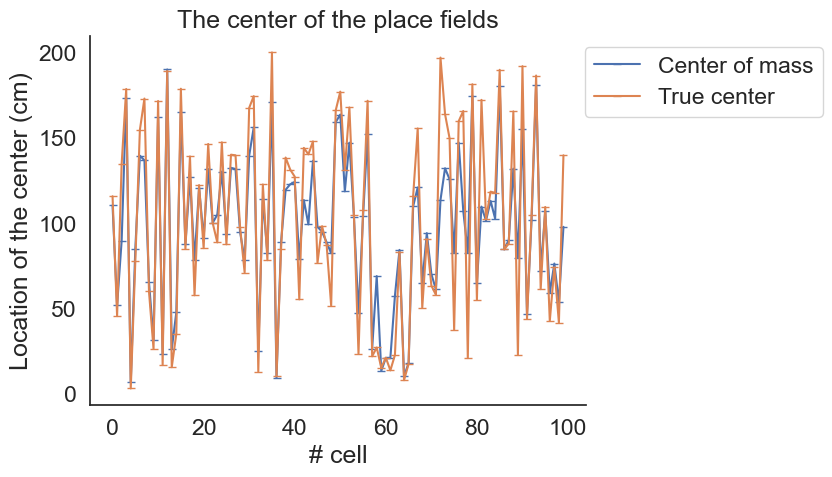

In [20]:
## Plot the center of mass and the centers of the place fields
plt.plot(c_pf, '_-',label='Center of mass')
plt.plot(pf_centers, '_-',label='True center')
plt.xlabel('# cell')
plt.ylabel('Location of the center (cm)')
plt.title('The center of the place fields')
plt.legend(bbox_to_anchor=(1.5, 1.))
plt.show()

## Exercise 2 - mutual information
---
A - Implement the mutual information formula discussed in the lesson, and apply it to the place cell data we simulated.

B - Adapt the simulation so that you can systematically vary 1) Peak firing rate, 2) place cell size 3) baseline noise. 
Study how mutual information vary with these parameters. Use both definition of mutual information above, and discuss the differences between them. Make some plots to show how the dependency goes.

### A

In [21]:
## General parameters
epsilon =  sys.float_info.epsilon
lamb = 5
lamb_x,occupancy = create_firing_rate_maps(spike_positions,track_length,binsize=1)

In [22]:
# Standard
def mutual_information(lamb_x,occupancy,lamb=5,n_cells=100):
    mut_inf = []
    for i in range(1,n_cells):
        mut_inf.append(np.sum((lamb_x[i])*np.log((lamb_x[i])+epsilon)/lamb)*occupancy[i])
    return mut_inf

### B

In [23]:
## Adjust peak firing rate
def plot_unit(peak):
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(1,n_cells), mutual_information(lamb_x,occupancy,lamb=peak))
    plt.xlabel('# cell')
    plt.ylabel('Mutual information')

interact(plot_unit, peak = widgets.IntSlider(min=1, max=15, value=5))
plt.show()

interactive(children=(IntSlider(value=5, description='peak', max=15, min=1), Output()), _dom_classes=('widget-…

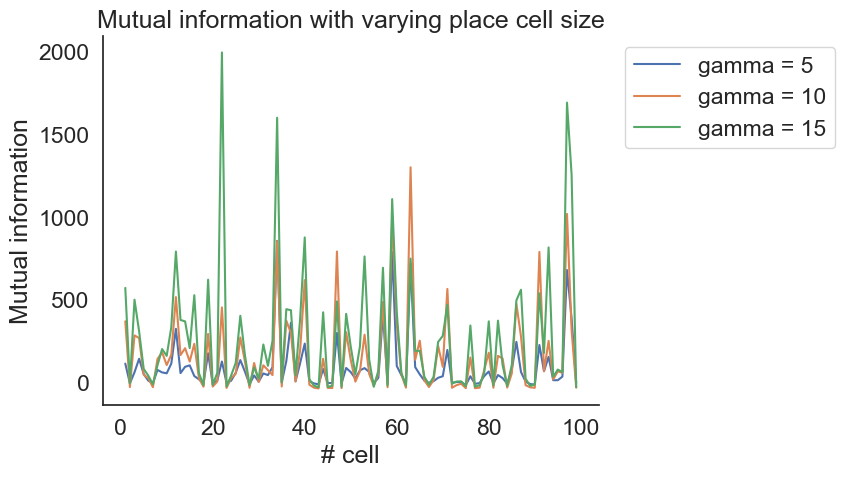

In [24]:
## Adjust the place cell size (gamma distribution)
def change_size(gamma):
    pf_size = np.random.gamma(gamma, size=n_cells)
    return pf_size
    
pf_size_5 = change_size(5)
pf_size_15 = change_size(15)

lamb_x_5 = create_data(pf_centers,pf_size_5,pf_rate,n_cells=100,track_length=200)
lamb_x_15 = create_data(pf_centers,pf_size_15,pf_rate,n_cells=100,track_length=200)

plt.plot(np.arange(1,n_cells), mutual_information(lamb_x_5,occupancy,lamb=5),label='gamma = 5')
plt.plot(np.arange(1,n_cells), mutual_information(lamb_x,occupancy,lamb=5),label='gamma = 10')
plt.plot(np.arange(1,n_cells), mutual_information(lamb_x_15,occupancy,lamb=5),label='gamma = 15')
plt.xlabel('# cell')
plt.ylabel('Mutual information')
plt.title('Mutual information with varying place cell size')
plt.legend(bbox_to_anchor=(1.5,1))
plt.show()

In [25]:
## Adjust the amount of noise

# Noise-level = 1.
spikes_noisy_1 = draw_spikes(x,t,n_cells,noise_firing_rate = 1)
spike_positions_noisy_1 = [np.interp(s, t, x) for s in spikes_noisy_1]

# Noise-level = 5.
spikes_noisy_5 = draw_spikes(x,t,n_cells,noise_firing_rate = 5)
spike_positions_noisy_5 = [np.interp(s, t, x) for s in spikes_noisy_5]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.19it/s]


In [26]:
lamb_x_noisy_1,occupancy_1 = create_firing_rate_maps(spike_positions_noisy_1,track_length=200.,binsize=1)
lamb_x_noisy_5,occupancy_5 = create_firing_rate_maps(spike_positions_noisy_5,track_length=200.,binsize=1)
lamb_x,occupancy = create_firing_rate_maps(spike_positions,track_length=200.,binsize=1)

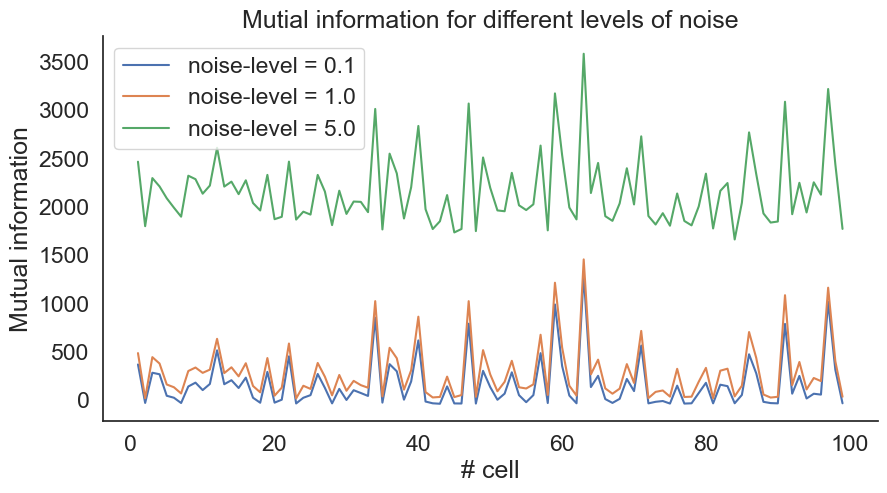

In [27]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,n_cells), mutual_information(lamb_x,occupancy,lamb=5),label='noise-level = 0.1')
plt.plot(np.arange(1,n_cells), mutual_information(lamb_x_noisy_1,occupancy_1,lamb=5),label='noise-level = 1.0')
plt.plot(np.arange(1,n_cells), mutual_information(lamb_x_noisy_5,occupancy_5,lamb=5),label='noise-level = 5.0')
plt.legend()
plt.xlabel('# cell')
plt.ylabel('Mutual information')
plt.title('Mutial information for different levels of noise')
plt.show()

Mutual information indicates the amount of surprise that an event happens. If a place cell fires at one location only, the cell is location specific and the amount of surprise is high, In this case the mutual information is low. As the peak firing rate is increased the mutual information decreases greatly. This suggests that the place cells are more specific if the peak firing rate is higher and there is more spiking at a specific location. The mutual information increases slightly if the place cell size is broadened, this is because the location becomes less precise. The level of noise has a great importance in the amount of mutual information. The mutual information increases as the noise is increased. So the place cells are less spatial specific.

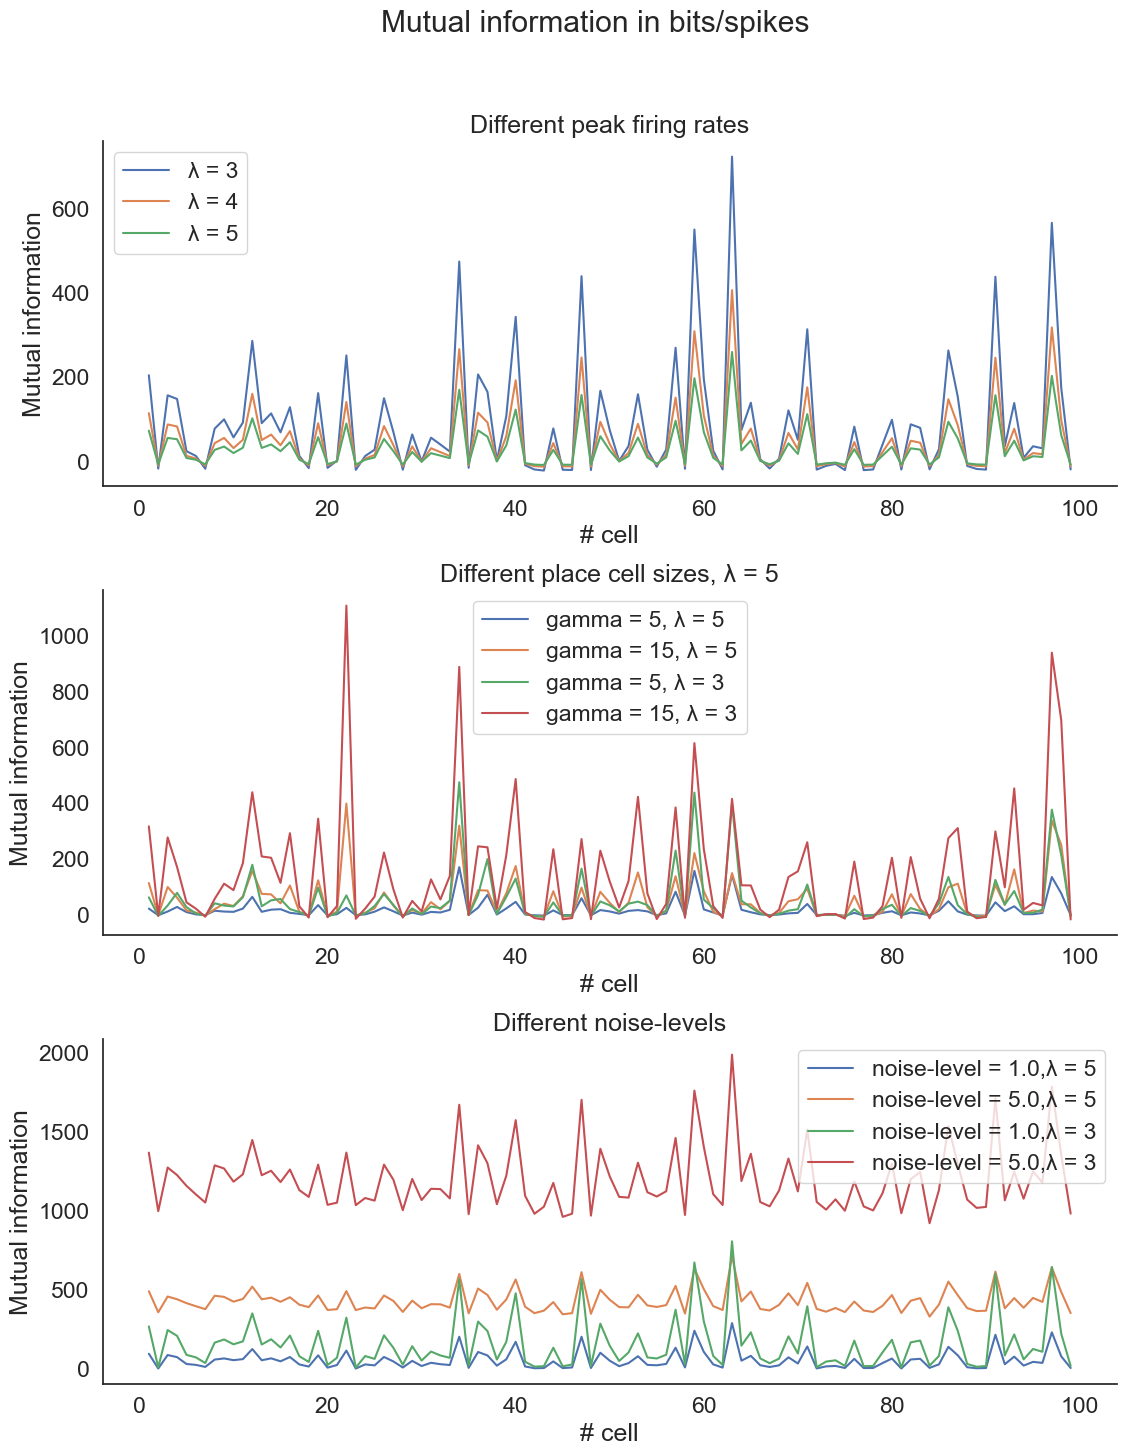

In [28]:
# Mutual information in bits/spike
fig, axs = plt.subplots(3, 1,figsize=(12,15))
fig.suptitle('Mutual information in bits/spikes')
fig.tight_layout(pad=2.5)

axs[0].plot(np.arange(1,n_cells), np.array(mutual_information(lamb_x,occupancy,lamb=3))/3,label='\u03BB = 3')
axs[0].plot(np.arange(1,n_cells), np.array(mutual_information(lamb_x,occupancy,lamb=4))/4,label='\u03BB = 4')
axs[0].plot(np.arange(1,n_cells), np.array(mutual_information(lamb_x,occupancy,lamb=5))/5,label='\u03BB = 5')
axs[0].set(xlabel='# cell', ylabel='Mutual information')
axs[0].set_title('Different peak firing rates')
axs[0].legend()

axs[1].plot(np.arange(1,n_cells), np.array(mutual_information(lamb_x_5,occupancy,lamb=5))/5,label='gamma = 5, \u03BB = 5')
axs[1].plot(np.arange(1,n_cells), np.array(mutual_information(lamb_x_15,occupancy,lamb=5))/5,label='gamma = 15, \u03BB = 5')
axs[1].plot(np.arange(1,n_cells), np.array(mutual_information(lamb_x_5,occupancy,lamb=3))/3,label='gamma = 5, \u03BB = 3')
axs[1].plot(np.arange(1,n_cells), np.array(mutual_information(lamb_x_15,occupancy,lamb=3))/3,label='gamma = 15, \u03BB = 3')
axs[1].set(xlabel='# cell', ylabel='Mutual information')
axs[1].set_title('Different place cell sizes, \u03BB = 5')
axs[1].legend()

axs[2].plot(np.arange(1,n_cells), np.array(mutual_information(lamb_x_noisy_1,occupancy_1,lamb=5))/5,label='noise-level = 1.0,\u03BB = 5')
axs[2].plot(np.arange(1,n_cells), np.array(mutual_information(lamb_x_noisy_5,occupancy_5,lamb=5))/5,label='noise-level = 5.0,\u03BB = 5')
axs[2].plot(np.arange(1,n_cells), np.array(mutual_information(lamb_x_noisy_1,occupancy_1,lamb=3))/3,label='noise-level = 1.0,\u03BB = 3')
axs[2].plot(np.arange(1,n_cells), np.array(mutual_information(lamb_x_noisy_5,occupancy_5,lamb=3))/3,label='noise-level = 5.0,\u03BB = 3')
axs[2].set(xlabel='# cell', ylabel='Mutual information')
axs[2].set_title('Different noise-levels')
axs[2].legend()

plt.show()

When we consider mutual information in bits per spike. The peak firing rate plays an important role in reducing the mutual information. Therefore as the peak firing rate is increased, the mutual information decreases even more. This can also be shown in the cases where the noise-level and gamma distribution have been altered.

## Exercise 3 - working with real data
---
Load the data from `linear_track_data.pickle`. It contains neural recordings from a mouse running on a linear track.
- `x` contains the position of the animal
- `t` contains the corresponding times, in seconds
- `spikes` contains a list of lists. Each list contains the timestamps of the spikes emitted by a neuron.

A - Visualiaze the position a s a function of time. Plot the spike of a selected cell in space.

B - Calculate the firing rate maps for all the cells, and plot them sorted by increasing peak positon.

C - Calculate the spatial information for each cell, and plot the distribution. Plot the firing rate maps of the 5 cells with lower spatial information, and the firing rate maps of the 5 cells with higher spatial information. Comment on the differences.

### A

In [29]:
## Import data
with open('data/linear_track_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

position = data['x']
time = data['t']
linear_spikes = data['spikes']

def plot_unit(i):
    plt.figure(figsize=(10,5))
    plt.plot(time, position)
    plt.plot(linear_spikes[i], np.interp(linear_spikes[i], time, position), 'r.')
    plt.xlabel('Time (s)')
    plt.ylabel('position on track (cm)')

interact(plot_unit, i = widgets.IntSlider(min=0, max=(len(linear_spikes)-1), value=0))
plt.show()

interactive(children=(IntSlider(value=0, description='i', max=71), Output()), _dom_classes=('widget-interact',…

### B

In [30]:
linear_spike_positions = [np.interp(s, time, position) for s in linear_spikes]

In [31]:
space_bins = np.arange(min(position), max(position), 0.5)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in linear_spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
linear_occupancy = np.histogram(position, space_bins)[0] /  fps

linear_firing_rate_maps = spikes_hist / (linear_occupancy+epsilon) 

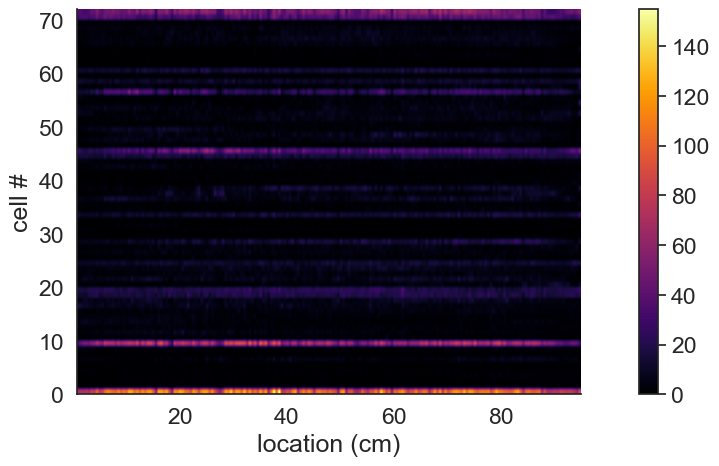

In [32]:
## Firing rate maps of the linear track dataset
plt.figure(figsize=(15,5))
plt.imshow(linear_firing_rate_maps, cmap='inferno', extent = [min(position), max(position), 0, len(linear_spikes)])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()
plt.show()

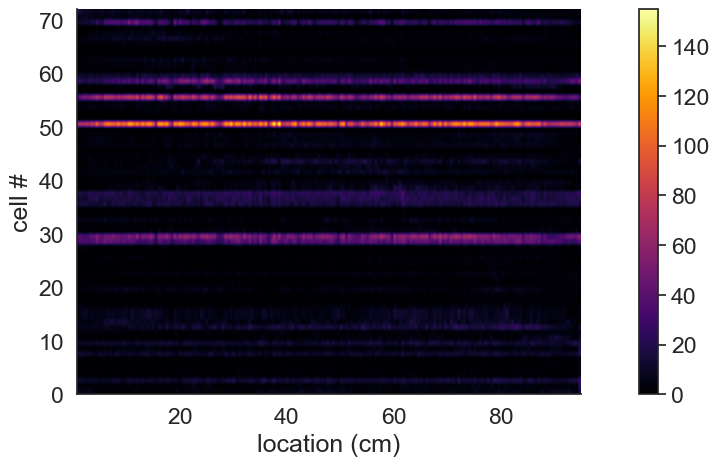

In [33]:
## Firing rate maps sorted by increasing peak position
plt.figure(figsize=(15,5))
linear_peak_locations = linear_firing_rate_maps.argmax(axis=1)
ix = np.argsort(linear_peak_locations)
plt.imshow(linear_firing_rate_maps[ix,:], cmap='inferno', extent = [min(position), max(position), 0, len(linear_spikes)])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()
plt.show()

### C

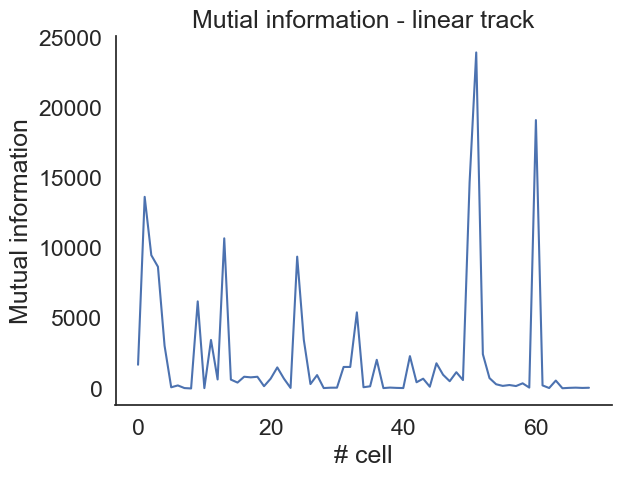

In [34]:
linear_mu_info = mutual_information(linear_firing_rate_maps,linear_occupancy,lamb=5,n_cells=len(linear_firing_rate_maps))
linear_mu_info = linear_mu_info[1:-1] # The first and last element are removed because they are atypical
plt.plot(linear_mu_info)
plt.xlabel('# cell')
plt.ylabel('Mutual information')
plt.title('Mutial information - linear track')
plt.show()

In [35]:
# Sort the mutual information values and store the order and the index of the order
sorted_linear_mu = sorted(linear_mu_info)
sorted_arg_linear_mu = np.argsort(linear_mu_info)

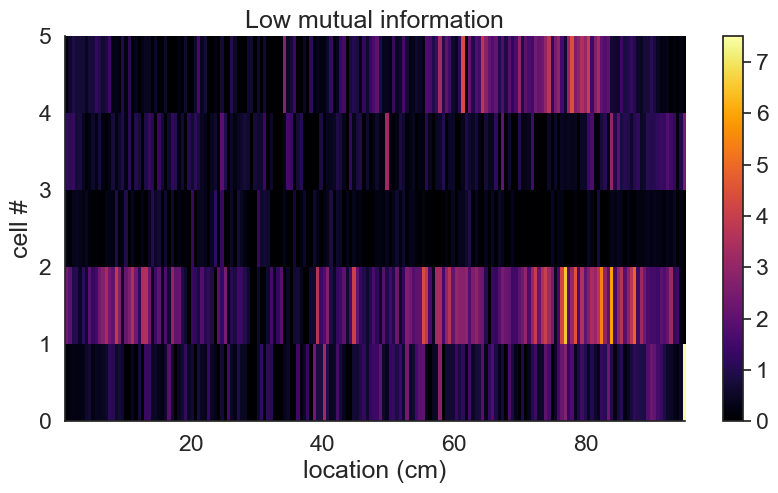

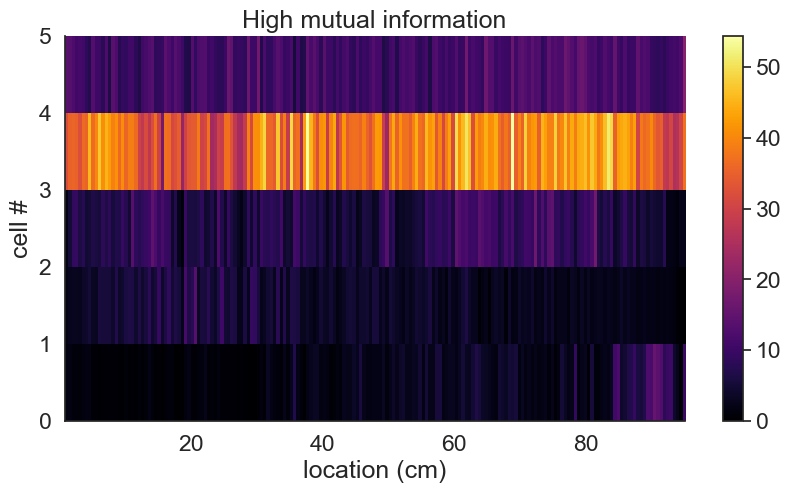

In [36]:
# The 5 firing maps with the LOWEST mutual information values:
plt.figure(figsize=(10,5))
plt.imshow(linear_firing_rate_maps[sorted_arg_linear_mu[:5]], cmap='inferno', extent = [min(position), max(position), 0, 5], aspect='auto', interpolation='nearest')
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.title('Low mutual information')
plt.colorbar()
plt.show()

# The 5 firing maps with the HIGHEST mutual information values:
plt.figure(figsize=(10,5))
plt.imshow(linear_firing_rate_maps[sorted_arg_linear_mu[-5:]], cmap='inferno', extent = [min(position), max(position), 0, 5], aspect='auto', interpolation='nearest')
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.title('High mutual information')
plt.colorbar()
plt.show()

Although non of the cells in this track are highly spatial selective, there are a few cells that do show a little bit of location selective spiking as can be seen in the top figure above. The firing rate maps with a high degree of mutual information are the least spatial selective. The lower figure above shows this very well for cell # 4 and 5 as they fire equaly for each location.